In [121]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import itertools
%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [122]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import keras_metrics
import multiap_cnn_model
import time  
import ap_cnn_model


In [123]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [124]:
def extract_patterns(data,extract=False):
    if(extract):
        patterns = {}
        for index, row in data.iterrows():
            patterns[row['index']] = set(get_pattern([row['text']])[0].values())
            print('Extracted pattern from '+ row['index'] + ' index:'+ str(index))
            print('Size: ', len(patterns[row['index']]), 'Patterns size', len(patterns))
        try:
            print('Saving Pickle')
            with open('pickles/patterns/pattern.pickle','wb') as f:
                save = {
                    'patterns' : patterns
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved in pattern.pickle')
                return patterns
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
            return patterns
    else:
        try:
            with open('pickles/patterns/pattern.pickle','rb') as f:
                save = pickle.load(f)
                patterns = save['patterns']
                del save
                returning = {}
                for key in list(data['index']):
                    returning[key] = patterns[key]
                return returning
        except Exception as e:
            print('Error loading base datasets pickle: ', e)
            
def clean_text(text, remove_actions= True):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    if(remove_actions):
        text = re.sub(r" ?\[[^)]+\]", "", text)
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]


def remove_empty_patterns(data,patterns):
    empty_patterns = [k for k, v in patterns.items() if len(v) < 1]
    patterns = { k:v for k, v in patterns.items() if len(v) >= 1 }
    data = filter(lambda x: x[1]['index'] not in empty_patterns ,data.iterrows())
    data = pd.DataFrame.from_items(data).T
    return data,patterns

def remove_multiwildcard(patterns):
    for index, patt in patterns.items():
        flt_patt = {p for p in patt if p.split(' ').count('.+') == 1}
        patterns[index] = flt_patt
    return patterns

def load_data(word_count,emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    #Remove rows that don't have Alignment file
    try:
        data = data.drop(no_alignment_file)
    except Exception as e:
        print('Error at: ',e)
    # Remove rows that have wrong Alignment file
    try:
        data = data.drop(wrong_alignment)
    except Exception as e:
        print('Error at: ',e)
#     Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
    patterns = extract_patterns(data)
    data,patterns = remove_empty_patterns(data,patterns)
    patterns = remove_multiwildcard(patterns)
    return data,patterns

def load_acoustic_fullmatrices(extraction_type = 'full',extract_fd = False):
    if(extraction_type in ['full','wc','cw']):
        try:
            if(extract_fd):
                fullmfcc_matrix_fd = None
                fullrmse_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix FULLDATA')
                fullzcr_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix FULLDATA')   
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix_fd.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix_fd = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices FULLDATA')
                fullmfcc_matrix_fd.append(fullrmse_matrix_fd)
                fullmfcc_matrix_fd.append(fullzcr_matrix_fd)
                return fullmfcc_matrix_fd
            else:
                fullmfcc_matrix = None
                fullrmse_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix')   
                fullzcr_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix')
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices') 
                fullmfcc_matrix.append(fullrmse_matrix)
                fullmfcc_matrix.append(fullzcr_matrix)
                return fullmfcc_matrix
        except Exception as e:
            print('Error loading matrix: ', e)
    else:
        print('Error')
        return None,None


In [125]:
# DATASET
seed = 7
np.random.seed(seed)
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}

data, patterns = load_data(2,emotional_mapping)
# x_train, x_test, y_train, y_test = train_test_split(data, data.emotion_code, test_size=TEST_SIZE)
try:
    with open('pickles/matrix_basedata.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

    
data.groupby('emotion').count()['index']

Error at:  labels [4764] not contained in axis


emotion
ang    1178
hap     722
neu    1566
sad    1008
Name: index, dtype: int64

## Create y labels for Binary Models

In [132]:
# y_train = pd.get_dummies(y_train).values
# y_test = pd.get_dummies(y_test).values
ang_mapping = {0:1,1:0,2:0,3:0}
hap_mapping = {0:0,1:1,2:0,3:0}
sad_mapping = {0:0,1:0,2:1,3:0}

ang_train = y_train.map(ang_mapping)
ang_test = y_test.map(ang_mapping)
hap_train = y_train.map(hap_mapping)
hap_test = y_test.map(hap_mapping)
sad_train = y_train.map(sad_mapping)
sad_test = y_test.map(sad_mapping)

In [133]:
ang_train = pd.get_dummies(ang_train).values
ang_test = pd.get_dummies(ang_test).values
sad_train = pd.get_dummies(sad_train).values
sad_test = pd.get_dummies(sad_test).values
hap_train = pd.get_dummies(hap_train).values
hap_test = pd.get_dummies(hap_test).values

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

## Load Acoustic Matrices

In [112]:
# full_matrices = load_acoustic_fullmatrices(extraction_type='full')
# wc_matrices = load_acoustic_fullmatrices(extraction_type='wc')
# cw_matrices = load_acoustic_fullmatrices(extraction_type='cw')
##################### FULLDATA ACOUSTIC MATRICES ###################################
full_matrices = load_acoustic_fullmatrices(extraction_type='full',extract_fd = True)
wc_matrices = load_acoustic_fullmatrices(extraction_type='wc',extract_fd = True)
cw_matrices = load_acoustic_fullmatrices(extraction_type='cw',extract_fd = True)
########################################################################################
RMSE_INDEX = 20
ZCR_INDEX = 21
###########################################################################################

em_df = pd.read_pickle('pickles/patterns/pfief_matrix.pickle')

patterns_list = np.array(list(em_df.index))
print(len(em_df),len(full_matrices),len(wc_matrices),len(cw_matrices))

Successfully loaded full RMSE Matrix FULLDATA
Successfully loaded full ZCR Matrix FULLDATA
Successfully loaded full MFCC Matrices FULLDATA
Successfully loaded wc RMSE Matrix FULLDATA
Successfully loaded wc ZCR Matrix FULLDATA
Successfully loaded wc MFCC Matrices FULLDATA
Successfully loaded cw RMSE Matrix FULLDATA
Successfully loaded cw ZCR Matrix FULLDATA
Successfully loaded cw MFCC Matrices FULLDATA
5853 22 22 22


In [113]:
def get_frequency_vectors(data,patterns_list):
    patterns = extract_patterns(data)
    transcript_order = list(data['index'])
    frequency_vectors = []
    for index in patterns:
        frequency_vectors.append(np.isin(patterns_list,np.array(list(patterns[index]))))
    vectors = pd.DataFrame(frequency_vectors,columns=patterns_list,index=patterns.keys())
    vectors = vectors.loc[transcript_order]
    vectors = vectors * 1
    return vectors

vectors = get_frequency_vectors(X_train,patterns_list)
test_vectors = get_frequency_vectors(X_test,patterns_list)

In [114]:
vectors.head(1)

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses04F_script03_2_M001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
test_vectors.head(1)

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses05F_impro02_F024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Parameter

In [116]:
# EMBEDDING
EMBEDDING_DIM  = 4
MAX_SEQ_LENGTH = 170

# MODEL
FILTER_SIZES   = [1,1,1]
FEATURE_MAPS   = [150,150,150]
DROPOUT_RATE   = 0.2

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 50
RUNS           = 5
VAL_SIZE       = 0.2
LEARNING_RATE  = 0.01

# Build Baseline Frequency Vectors

In [117]:
result = [np.sum(x[1]) for x in vectors.iterrows()]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    data.append(pad)
    

test_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    test_data.append(pad)


Text informations:
max length: 165 / min length: 1 / mean length: 25 / limit length: 170


In [118]:
np.array(data).shape, y_train.shape, np.array(test_data).shape, y_test.shape

((3366, 170, 4), (3366,), (842, 170, 4), (842,))

# Conv1D Baseline

## Binary Models Training

In [40]:
# histories = []

# start_time = time.time()
# emb_layer = None

# ang_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# ang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = ang_model.fit(
#     [data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

# ####### SADNESS #######
# start_time = time.time()
# sad_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# sad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = sad_model.fit(
#     [data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

# ####### HAPPY #######
# start_time = time.time()
# hap_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# hap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = hap_model.fit(
#     [data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 8s 2ms/step - loss: 1.3185 - acc: 0.6806 - precision: 0.6806 - recall: 0.6806 - val_loss: 1.2923 - val_acc: 0.7268 - val_precision: 0.7268 - val_recall: 0.7268
Epoch 2/50
3366/3366 [==============================] - 6s 2ms/step - loss: 1.2741 - acc: 0.7285 - precision: 0.7285 - recall: 0.7285 - val_loss: 1.2726 - val_acc: 0.7280 - val_precision: 0.7280 - val_recall: 0.7280
Epoch 3/50
3366/3366 [==============================] - 6s 2ms/step - loss: 1.2547 - acc: 0.7329 - precision: 0.7329 - recall: 0.7329 - val_loss: 1.2549 - val_acc: 0.7268 - val_precision: 0.7268 - val_recall: 0.7268
Epoch 4/50
3366/3366 [==============================] - 6s 2ms/ste

3366/3366 [==============================] - 6s 2ms/step - loss: 0.9937 - acc: 0.8523 - precision: 0.8523 - recall: 0.8523 - val_loss: 1.0391 - val_acc: 0.8337 - val_precision: 0.8337 - val_recall: 0.8337
Epoch 24/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9863 - acc: 0.8523 - precision: 0.8523 - recall: 0.8523 - val_loss: 1.0342 - val_acc: 0.8361 - val_precision: 0.8361 - val_recall: 0.8361
Epoch 25/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9799 - acc: 0.8520 - precision: 0.8520 - recall: 0.8520 - val_loss: 1.0299 - val_acc: 0.8385 - val_precision: 0.8385 - val_recall: 0.8385
Epoch 26/50
3366/3366 [==============================] - 7s 2ms/step - loss: 0.9769 - acc: 0.8553 - precision: 0.8553 - recall: 0.8553 - val_loss: 1.0246 - val_acc: 0.8385 - val_precision: 0.8385 - val_recall: 0.8385
Epoch 27/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9671 - acc: 0.8610 - precision: 0.8610 - recall: 0.8610 - val_los

Epoch 47/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9132 - acc: 0.8535 - precision: 0.8535 - recall: 0.8535 - val_loss: 0.9908 - val_acc: 0.8207 - val_precision: 0.8207 - val_recall: 0.8207
Epoch 48/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9080 - acc: 0.8580 - precision: 0.8580 - recall: 0.8580 - val_loss: 0.9895 - val_acc: 0.8254 - val_precision: 0.8254 - val_recall: 0.8254
Epoch 49/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9005 - acc: 0.8559 - precision: 0.8559 - recall: 0.8559 - val_loss: 0.9847 - val_acc: 0.8230 - val_precision: 0.8230 - val_recall: 0.8230
Epoch 50/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9012 - acc: 0.8613 - precision: 0.8613 - recall: 0.8613 - val_loss: 0.9855 - val_acc: 0.8254 - val_precision: 0.8254 - val_recall: 0.8254
Iteration finished
--- 401.99599719047546 seconds on ---


## Binary Models Conf Matrix, Precision and Recall

In [119]:
# ang_test_predictions = ang_model.predict([test_data],verbose=1)
# sad_test_predictions = sad_model.predict([test_data],verbose=1)
# hap_test_predictions = hap_model.predict([test_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)

842/842 [==============================] - 4s 5ms/step


In [ ]:
# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Overall Model Training

In [50]:
histories = []
start_time = time.time()
model = ap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo=4
)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
)

history = model.fit(
    [data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print('Iteration finished' )
print("--- %s seconds on ---" % (time.time() - start_time))

# binarycross - val_acc: 0.7625 - val_precision: 0.9852 - val_recall: 0.0511
# binarycross with categorical accuracy - val_categorical_accuracy: 0.4857 - val_precision: 1.0000 - val_recall: 0.0570
# categorical cross - val_categorical_accuracy: 0.5380 - val_precision: 0.9901 - val_recall: 0.0986

Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 8s 2ms/step - loss: 1.2506 - acc: 0.7498 - precision: 0.4437 - recall: 0.0083 - val_loss: 1.2388 - val_acc: 0.7503 - val_precision: 0.2375 - val_recall: 0.0012
Epoch 2/50
3366/3366 [==============================] - 7s 2ms/step - loss: 1.2322 - acc: 0.7521 - precision: 0.7051 - recall: 0.0172 - val_loss: 1.2264 - val_acc: 0.7512 - val_precision: 0.4751 - val_recall: 0.0048
Epoch 3/50
3366/3366 [==============================] - 7s 2ms/step - loss: 1.2158 - acc: 0.7544 - precision: 0.7914 - recall: 0.0250 - val_loss: 1.2160 - val_acc: 0.7521 - val_precision: 0.7625 - val_recall: 0.0083
Epoch 4/50
3366/3366 [==============================] - 6s 2ms/ste

In [53]:
model.save('cnn_models/binbaseline.h5')

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 0s 428us/step
Confusion matrix, without normalization


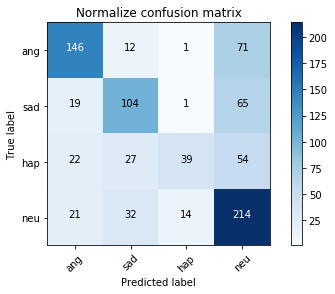

Precision Weighted:  0.6214961418487911
Recall Weighted:  0.5973871733966746
Precision Micro:  0.5973871733966746
Recall Micro:  0.5973871733966746
Precision Macro:  0.6337506676491825
Recall Macro:  0.5553152206457697


In [58]:
test_predictions = model.predict([test_data],verbose=1)
y_pred = np.argmax(test_predictions,axis=1)
y_true = np.argmax(y_test,axis=1)
cnf_matrix = confusion_matrix(y_true,y_pred)
precision = precision_score(y_true,y_pred,average="weighted")
recall = recall_score(y_true,y_pred,average="weighted")
precision_mic = precision_score(y_true,y_pred,average="micro")
recall_mic = recall_score(y_true,y_pred,average="micro")
precision_mac = precision_score(y_true,y_pred,average="macro")
recall_mac = recall_score(y_true,y_pred,average="macro")

EMO_SET = ['ang','sad','hap','neu']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=EMO_SET,normalize=False, title='Normalize confusion matrix')
plt.show()
print('Precision Weighted: ',precision)
print('Recall Weighted: ',recall)
print('Precision Micro: ',precision_mic)
print('Recall Micro: ',recall_mic)
print('Precision Macro: ',precision_mac)
print('Recall Macro: ',recall_mac)



In [99]:
for i,val in enumerate(EMO_SET):
    diag = cnf_matrix[i][i]
    for_recall = sum(cnf_matrix[i,:])
    for_precision = sum(cnf_matrix[:,i])
    print('Emo ' ,val, diag/for_precision, diag/for_recall)
print('Overall Model',precision, recall)

Emo  ang 0.7019230769230769 0.6347826086956522
Emo  sad 0.5942857142857143 0.5502645502645502
Emo  hap 0.7090909090909091 0.2746478873239437
Emo  neu 0.5297029702970297 0.7615658362989324
Overall Model 0.6214961418487911 0.5973871733966746


Training: 	0.9148 loss / 0.8415 acc
Validation: 	0.9782 loss / 0.8141 acc


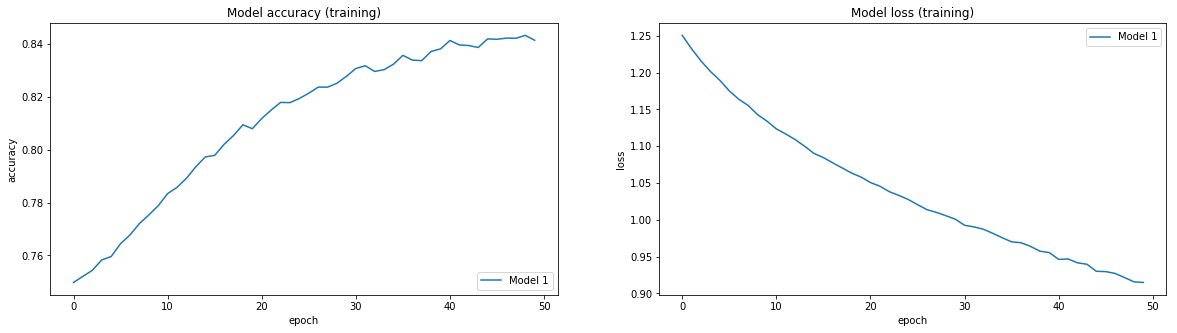

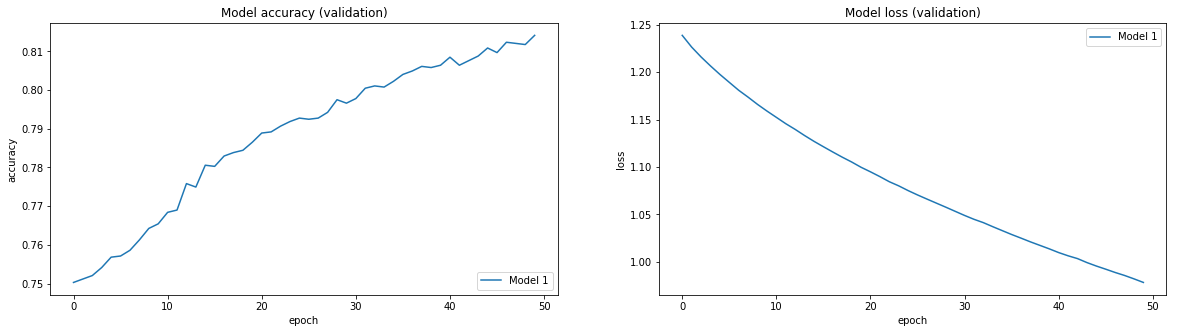

In [56]:
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

# Multichannel CNN - RMSE

## Build Multichannel Frequency Vectors

In [59]:
acoustic_matrix = full_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])



In [60]:
acoustic_matrix = cw_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

In [61]:
acoustic_matrix = wc_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

In [62]:
np.array(full_data).shape, y_train.shape, np.array(test_full_data).shape, y_test.shape

((3366, 2, 170, 4), (3366, 4), (842, 2, 170, 4), (842, 4))

In [63]:
np.array(cw_data).shape, np.array(wc_data).shape, np.array(test_cw_data).shape, np.array(test_wc_data).shape

((3366, 2, 170, 4), (3366, 2, 170, 4), (842, 2, 170, 4), (842, 2, 170, 4))

In [161]:
def run_models(full_data,test_full_data, wc_data, test_wc_data, cw_data, test_cw_data, loss='binary_crossentropy',num_emo = 4):
    histories = []
    print('Running iteration 1/3')
    start_time = time.time()

    wc_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo= num_emo
    )

    wc_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = wc_model.fit(
        [wc_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_wc_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print("--- %s seconds on ---" % (time.time() - start_time))
    #######

    print('Running iteration 2/3')
    start_time = time.time()

    cw_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo= num_emo
    )

    cw_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = cw_model.fit(
        [cw_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_cw_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print("--- %s seconds on ---" % (time.time() - start_time))
    #######
    print('Running iteration 3/3')
    start_time = time.time()

    full_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo = num_emo
    )

    full_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = full_model.fit(
        [full_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_full_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration 3/3')
    print("--- %s seconds on ---" % (time.time() - start_time))
    return full_model, wc_model, cw_model, histories

## Binary Models Training - Wild Cards Feature Extraction

In [162]:
# ###### ANGER #######
# histories = []
# print('Running iteration 1/1' )
# start_time = time.time()
# emb_layer = None

# wcang_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wcang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wcang_model.fit(
#     [wc_data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### SADNESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# wcsad_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wcsad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wcsad_model.fit(
#     [wc_data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### HAPINESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# wchap_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wchap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wchap_model.fit(
#     [wc_data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

## Binary Models ConfMatrix, Precision and Recall - Wild Cards Feature Extraction

In [163]:
# ang_test_predictions = wcang_model.predict([test_wc_data],verbose=1)
# sad_test_predictions = wcsad_model.predict([test_wc_data],verbose=1)
# hap_test_predictions = wchap_model.predict([test_wc_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)



In [164]:
# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Binary Models Training - Content Word Feature Extraction

In [165]:
# ###### ANGER #######
# histories = []
# print('Running iteration 1/1' )
# start_time = time.time()
# emb_layer = None

# cwang_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwang_model.fit(
#     [cw_data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### SADNESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# cwsad_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwsad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwsad_model.fit(
#     [cw_data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### HAPINESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# cwhap_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwhap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwhap_model.fit(
#     [cw_data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

## Binary Models ConfMatrix, Precision and Recall - Content Words Feature Extraction

In [166]:

# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# ang_test_predictions = cwang_model.predict([test_cw_data],verbose=1)
# sad_test_predictions = cwsad_model.predict([test_cw_data],verbose=1)
# hap_test_predictions = cwhap_model.predict([test_cw_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)

# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Overall Model Training

In [70]:
full_model, wc_model, cw_model , histories = run_model(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 15s 4ms/step - loss: 1.2801 - acc: 0.7495 - precision: 0.3375 - recall: 0.0039 - val_loss: 1.2670 - val_acc: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2575 - acc: 0.7516 - precision: 0.6494 - recall: 0.0134 - val_loss: 1.2549 - val_acc: 0.7509 - val_precision: 0.4751 - val_recall: 0.0036
Epoch 3/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2439 - acc: 0.7548 - precision: 0.8061 - recall: 0.0261 - val_loss: 1.2447 - val_acc: 0.7515 - val_precision: 0.7126 - val_recall: 0.0059
Epoch 4/50
3366/3366 [===========

Epoch 23/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.0427 - acc: 0.8148 - precision: 0.9002 - recall: 0.2914 - val_loss: 1.0873 - val_acc: 0.7898 - val_precision: 0.8927 - val_recall: 0.1805
Epoch 24/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.0360 - acc: 0.8141 - precision: 0.8845 - recall: 0.2950 - val_loss: 1.0823 - val_acc: 0.7916 - val_precision: 0.8847 - val_recall: 0.1912
Epoch 25/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0331 - acc: 0.8148 - precision: 0.8770 - recall: 0.3010 - val_loss: 1.0776 - val_acc: 0.7925 - val_precision: 0.8981 - val_recall: 0.1912
Epoch 26/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0228 - acc: 0.8197 - precision: 0.8888 - recall: 0.3188 - val_loss: 1.0731 - val_acc: 0.7942 - val_precision: 0.8775 - val_recall: 0.2055
Epoch 27/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0188 - acc: 0.8196 - precision: 0.8867 - recall:

Epoch 9/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.1307 - acc: 0.7695 - precision: 0.9115 - recall: 0.0865 - val_loss: 1.1482 - val_acc: 0.7631 - val_precision: 1.0000 - val_recall: 0.0523
Epoch 10/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1207 - acc: 0.7729 - precision: 0.9010 - recall: 0.1025 - val_loss: 1.1423 - val_acc: 0.7648 - val_precision: 0.9644 - val_recall: 0.0618
Epoch 11/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.1124 - acc: 0.7776 - precision: 0.9272 - recall: 0.1197 - val_loss: 1.1348 - val_acc: 0.7660 - val_precision: 1.0000 - val_recall: 0.0641
Epoch 12/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1012 - acc: 0.7798 - precision: 0.9109 - recall: 0.1319 - val_loss: 1.1285 - val_acc: 0.7660 - val_precision: 0.9717 - val_recall: 0.0665
Epoch 13/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.0926 - acc: 0.7845 - precision: 0.8989 - recall: 

In [71]:
full_model.save('cnn_models/binrmse_full.h5')
cw_model.save('cnn_models/binrmse_cw.h5')
wc_model.save('cnn_models/binrmse_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

In [148]:
def get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data):
    full_test_predictions = full_model.predict([test_full_data],verbose=1)
    cw_test_predictions = cw_model.predict([test_cw_data],verbose=1)
    wc_test_predictions = wc_model.predict([test_wc_data],verbose=1)

    full_y_pred = np.argmax(full_test_predictions,axis=1)
    full_y_true = np.argmax(y_test,axis=1)

    cw_y_pred = np.argmax(cw_test_predictions,axis=1)
    cw_y_true = np.argmax(y_test,axis=1)

    wc_y_pred = np.argmax(wc_test_predictions,axis=1)
    wc_y_true = np.argmax(y_test,axis=1)
    
    full_cnf_matrix = confusion_matrix(full_y_true,full_y_pred)
    cw_cnf_matrix = confusion_matrix(cw_y_true,cw_y_pred)
    wc_cnf_matrix = confusion_matrix(wc_y_true,wc_y_pred)

#     full_precision =precision_score(full_y_true,full_y_pred,average='weighted')
#     full_recall = recall_score(full_y_true,full_y_pred,average='weighted')
#     cw_precision =precision_score(cw_y_true,cw_y_pred,average='weighted')
#     cw_recall = recall_score(cw_y_true,cw_y_pred,average='weighted')
#     wc_precision =precision_score(wc_y_true,wc_y_pred,average='weighted')
#     wc_recall = recall_score(wc_y_true,wc_y_pred,average='weighted')
    plt.figure()
    plot_confusion_matrix(full_cnf_matrix, classes=EMO_SET, normalize=False,
                          title='Normalized confusion matrix')

    plt.show()

    plt.figure()
    plot_confusion_matrix(cw_cnf_matrix, classes=EMO_SET, normalize=False,
                          title='Normalized confusion matrix')

    plt.show()

    plt.figure()
    plot_confusion_matrix(wc_cnf_matrix, classes=EMO_SET, normalize=False,
                          title='Normalized confusion matrix')

    plt.show()
    return full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix


EMO_SET = ['ang','sad','hap','neu']


Confusion matrix, without normalization


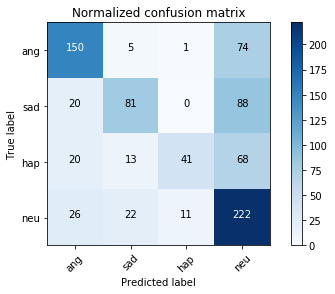

Full
Precision:  0.634329233158318
Recall:  0.5866983372921615
Confusion matrix, without normalization


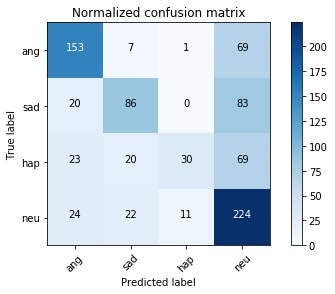

CW
Precision:  0.6214136673329607
Recall:  0.5855106888361045
Confusion matrix, without normalization


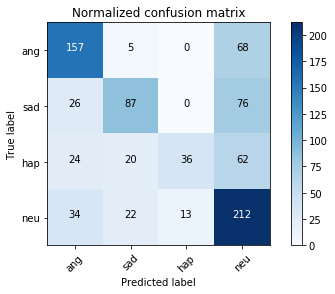

Happiness
Precision:  0.61684828639415
Recall:  0.5843230403800475


In [75]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [151]:
def get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix):
    for i,val in enumerate(EMO_SET):
        diag = full_cnf_matrix[i][i]
        for_recall = sum(full_cnf_matrix[i,:])
        for_precision = sum(full_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',', diag/for_recall)
    print('Overall Model',full_precision,',', full_recall)
    print('-')
    for i,val in enumerate(EMO_SET):
        diag = wc_cnf_matrix[i][i]
        for_recall = sum(wc_cnf_matrix[i,:])
        for_precision = sum(wc_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',' ,diag/for_recall)
    print('Overall Model',wc_precision,',', wc_recall)
    print('-')
    for i,val in enumerate(EMO_SET):
        diag = cw_cnf_matrix[i][i]
        for_recall = sum(cw_cnf_matrix[i,:])
        for_precision = sum(cw_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',', diag/for_recall)
    print('Overall Model',cw_precision,',', cw_recall)
    
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)

# Multichannel CNN - ZCR

## Build Multichannel Frequency Vectors

In [131]:
acoustic_matrix = full_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

## Overall Model Training

In [134]:
histories = []
print('Running iteration 1/3')
start_time = time.time()

wc_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

wc_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = wc_model.fit(
    [wc_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_wc_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print("--- %s seconds on ---" % (time.time() - start_time))
#######

print('Running iteration 2/3')
start_time = time.time()

cw_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

cw_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = cw_model.fit(
    [cw_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_cw_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print("--- %s seconds on ---" % (time.time() - start_time))
#######
print('Running iteration 3/3')
start_time = time.time()

full_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

full_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = full_model.fit(
    [full_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_full_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print('Iteration 3/3')
print("--- %s seconds on ---" % (time.time() - start_time))

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.2492 - acc: 0.7496 - val_loss: 1.2413 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2338 - acc: 0.7510 - val_loss: 1.2308 - val_acc: 0.7500
Epoch 3/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2203 - acc: 0.7527 - val_loss: 1.2209 - val_acc: 0.7503
Epoch 4/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2055 - acc: 0.7562 - val_loss: 1.2117 - val_acc: 0.7533
Epoch 5/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1929 - acc: 0.7610 - val_loss: 1.2028 - val_acc: 0.7530
Epoch 6/50
3366/3

3366/3366 [==============================] - 16s 5ms/step - loss: 1.1786 - acc: 0.7626 - val_loss: 1.1942 - val_acc: 0.7568
Epoch 7/50
3366/3366 [==============================] - 16s 5ms/step - loss: 1.1660 - acc: 0.7671 - val_loss: 1.1864 - val_acc: 0.7601
Epoch 8/50
3366/3366 [==============================] - 16s 5ms/step - loss: 1.1567 - acc: 0.7696 - val_loss: 1.1786 - val_acc: 0.7616
Epoch 9/50
3366/3366 [==============================] - 17s 5ms/step - loss: 1.1477 - acc: 0.7737 - val_loss: 1.1710 - val_acc: 0.7637
Epoch 10/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.1348 - acc: 0.7776 - val_loss: 1.1641 - val_acc: 0.7666
Epoch 11/50
3366/3366 [==============================] - 18s 5ms/step - loss: 1.1281 - acc: 0.7818 - val_loss: 1.1573 - val_acc: 0.7672
Epoch 12/50
3366/3366 [==============================] - 15s 5ms/step - loss: 1.1182 - acc: 0.7824 - val_loss: 1.1507 - val_acc: 0.7693
Epoch 13/50
3366/3366 [==============================] - 14s 4m

Epoch 14/50
3366/3366 [==============================] - 22s 6ms/step - loss: 1.1066 - acc: 0.7920 - val_loss: 1.1402 - val_acc: 0.7726
Epoch 15/50
3366/3366 [==============================] - 22s 7ms/step - loss: 1.0998 - acc: 0.7938 - val_loss: 1.1343 - val_acc: 0.7755
Epoch 16/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.0892 - acc: 0.8000 - val_loss: 1.1280 - val_acc: 0.7812
Epoch 17/50
3366/3366 [==============================] - 16s 5ms/step - loss: 1.0839 - acc: 0.7995 - val_loss: 1.1222 - val_acc: 0.7824
Epoch 18/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.0774 - acc: 0.8035 - val_loss: 1.1166 - val_acc: 0.7836
Epoch 19/50
3366/3366 [==============================] - 18s 5ms/step - loss: 1.0686 - acc: 0.8071 - val_loss: 1.1112 - val_acc: 0.7850
Epoch 20/50
3366/3366 [==============================] - 15s 5ms/step - loss: 1.0651 - acc: 0.8061 - val_loss: 1.1059 - val_acc: 0.7880
Epoch 21/50
3366/3366 [=========================

## Save Model or Load Model

In [173]:
# full_model.save('cnn_models/binzcr_full.h5')
# cw_model.save('cnn_models/binzcr_cw.h5')
# wc_model.save('cnn_models/binzcr_wc.h5')

full_model = keras.models.load_model('cnn_models/binzcr_full.h5')
cw_model = keras.models.load_model('cnn_models/binzcr_cw.h5')
wc_model = keras.models.load_model('cnn_models/binzcr_wc.h5')


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 1s 1ms/step
Confusion matrix, without normalization


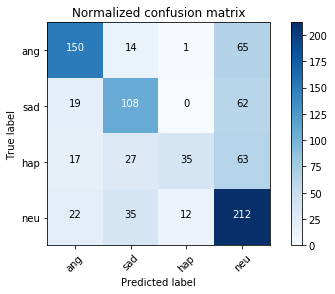

Confusion matrix, without normalization


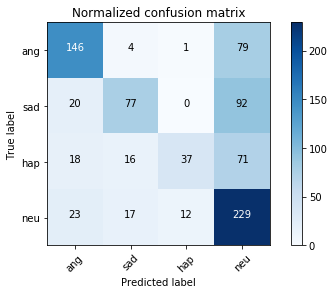

Confusion matrix, without normalization


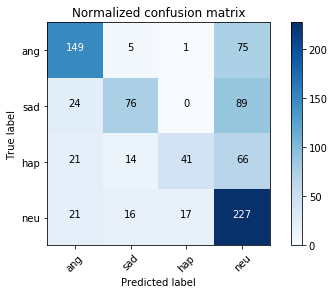

In [174]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [175]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)

Emo  ang 0.7211538461538461 , 0.6521739130434783
Emo  sad 0.5869565217391305 , 0.5714285714285714
Emo  hap 0.7291666666666666 , 0.24647887323943662
Emo  neu 0.527363184079602 , 0.7544483985765125
Overall Model 0.6250741718939488 , 0.6009501187648456
-
Emo  ang 0.6930232558139535 , 0.6478260869565218
Emo  sad 0.6846846846846847 , 0.4021164021164021
Emo  hap 0.6949152542372882 , 0.2887323943661972
Emo  neu 0.49671772428884026 , 0.8078291814946619
Overall Model 0.6279566320772266 , 0.5890736342042755
-
Emo  ang 0.7053140096618358 , 0.6347826086956522
Emo  sad 0.6754385964912281 , 0.4074074074074074
Emo  hap 0.74 , 0.2605633802816901
Emo  neu 0.4861995753715499 , 0.8149466192170819
Overall Model 0.6306870921020822 , 0.5795724465558195


# Multichannel CNN - MFCC1

## Build Multichannel Frequency Vectors

In [156]:
acoustic_matrix = full_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

## Overall Model Training

In [169]:
full_model, wc_model, cw_model , histories = run_models(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2993 - acc: 0.7490 - val_loss: 1.2837 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2796 - acc: 0.7497 - val_loss: 1.2722 - val_acc: 0.7500
Epoch 3/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2657 - acc: 0.7516 - val_loss: 1.2625 - val_acc: 0.7503
Epoch 4/50
3366/3366 [==============================] - 10s 3ms/step - loss: 1.2515 - acc: 0.7540 - val_loss: 1.2533 - val_acc: 0.7509
Epoch 5/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2391 - acc: 0.7548 - val_loss: 1.2449 - val_acc: 0.7527
Epoch 6/50
3366/3

3366/3366 [==============================] - 11s 3ms/step - loss: 1.1869 - acc: 0.7628 - val_loss: 1.2019 - val_acc: 0.7580
Epoch 7/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1758 - acc: 0.7651 - val_loss: 1.1934 - val_acc: 0.7598
Epoch 8/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1648 - acc: 0.7695 - val_loss: 1.1855 - val_acc: 0.7610
Epoch 9/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1544 - acc: 0.7738 - val_loss: 1.1778 - val_acc: 0.7643
Epoch 10/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1464 - acc: 0.7755 - val_loss: 1.1704 - val_acc: 0.7669
Epoch 11/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1338 - acc: 0.7769 - val_loss: 1.1638 - val_acc: 0.7675
Epoch 12/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1249 - acc: 0.7836 - val_loss: 1.1562 - val_acc: 0.7702
Epoch 13/50
3366/3366 [==============================] - 11s 3m

Epoch 14/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1065 - acc: 0.7847 - val_loss: 1.1383 - val_acc: 0.7714
Epoch 15/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0977 - acc: 0.7874 - val_loss: 1.1324 - val_acc: 0.7726
Epoch 16/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0900 - acc: 0.7902 - val_loss: 1.1264 - val_acc: 0.7752
Epoch 17/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0827 - acc: 0.7948 - val_loss: 1.1207 - val_acc: 0.7779
Epoch 18/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0753 - acc: 0.7957 - val_loss: 1.1150 - val_acc: 0.7785
Epoch 19/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0688 - acc: 0.7995 - val_loss: 1.1099 - val_acc: 0.7800
Epoch 20/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0612 - acc: 0.8015 - val_loss: 1.1046 - val_acc: 0.7809
Epoch 21/50
3366/3366 [=========================

## Save Model or Load Model

In [170]:
full_model.save('cnn_models/binmfcc1_full.h5')
cw_model.save('cnn_models/binmfcc1_cw.h5')
wc_model.save('cnn_models/binmfcc1_wc.h5')

# full_model = keras.models.load_model('cnn_models/binzcr_full.h5',custom_objects={'precision':keras_metrics.precision,'recall':keras_metrics.recall})
# cw_model = keras.models.load_model('cnn_models/binzcr_cw.h5')
# wc_model = keras.models.load_model('cnn_models/binzcr_wc.h5')


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 1s 1ms/step
Confusion matrix, without normalization


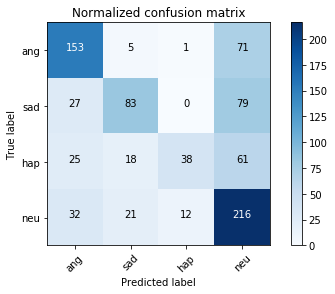

Confusion matrix, without normalization


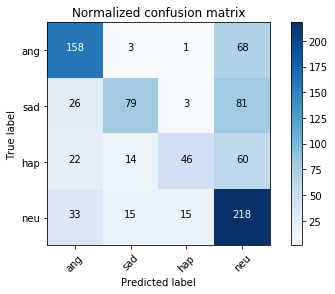

Confusion matrix, without normalization


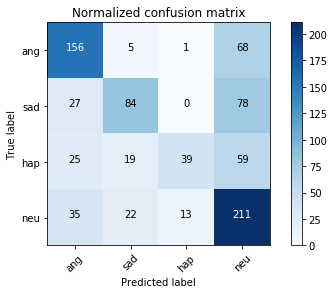

In [171]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [172]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)

Emo  ang 0.6455696202531646 , 0.6652173913043479
Emo  sad 0.6535433070866141 , 0.43915343915343913
Emo  hap 0.7450980392156863 , 0.2676056338028169
Emo  neu 0.5058548009367682 , 0.7686832740213523
Overall Model 0.6250741718939488 , 0.6009501187648456
-
Emo  ang 0.6419753086419753 , 0.6782608695652174
Emo  sad 0.6461538461538462 , 0.4444444444444444
Emo  hap 0.7358490566037735 , 0.2746478873239437
Emo  neu 0.5072115384615384 , 0.7508896797153025
Overall Model 0.6279566320772266 , 0.5890736342042755
-
Emo  ang 0.6610878661087866 , 0.6869565217391305
Emo  sad 0.7117117117117117 , 0.41798941798941797
Emo  hap 0.7076923076923077 , 0.323943661971831
Emo  neu 0.5105386416861827 , 0.7758007117437722
Overall Model 0.6306870921020822 , 0.5795724465558195


# Multichannel CNN - MFCC20

## Build Multichannel Frequency Vectors

In [38]:
# acoustic_matrix = full_matrices[RMSE_INDEX]
# acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))
NUM_CHANNELS = 21
acoustic_matrices = full_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
full_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    full_data.append(final)
    
test_full_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_full_data.append(final)

acoustic_matrices = cw_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

cw_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    cw_data.append(final)
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_cw_data.append(final)
  

acoustic_matrices = wc_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))


wc_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    wc_data.append(final)
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_wc_data.append(final)

## Overall Model Training

In [ ]:
full_model, wc_model, cw_model , histories = run_models(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 16s 5ms/step - loss: 1.2717 - acc: 0.7470 - val_loss: 1.2520 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.2477 - acc: 0.7507 - val_loss: 1.2406 - val_acc: 0.7518
Epoch 3/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2321 - acc: 0.7527 - val_loss: 1.2313 - val_acc: 0.7515
Epoch 4/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2214 - acc: 0.7542 - val_loss: 1.2228 - val_acc: 0.7530
Epoch 5/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.2097 - acc: 0.7574 - val_loss: 1.2148 - val_acc: 0.7559
Epoch 6/50
3366/3

3366/3366 [==============================] - 15s 4ms/step - loss: 1.2014 - acc: 0.7571 - val_loss: 1.2103 - val_acc: 0.7556
Epoch 7/50
3366/3366 [==============================] - 15s 4ms/step - loss: 1.1895 - acc: 0.7591 - val_loss: 1.2023 - val_acc: 0.7565
Epoch 8/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.1796 - acc: 0.7639 - val_loss: 1.1948 - val_acc: 0.7583
Epoch 9/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.1689 - acc: 0.7663 - val_loss: 1.1879 - val_acc: 0.7598
Epoch 10/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.1599 - acc: 0.7696 - val_loss: 1.1815 - val_acc: 0.7619
Epoch 11/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.1489 - acc: 0.7747 - val_loss: 1.1739 - val_acc: 0.7637
Epoch 12/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.1401 - acc: 0.7771 - val_loss: 1.1679 - val_acc: 0.7651
Epoch 13/50
3366/3366 [==============================] - 13s 4m

In [ ]:
full_model.save('cnn_models/binmfcc20_full.h5')
cw_model.save('cnn_models/binmfcc20_cw.h5')
wc_model.save('cnn_models/binmfcc20_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

In [ ]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [ ]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)

((3366, 21, 170, 4), (3366, 4), (842, 21, 170, 4), (842, 4))

In [41]:
import multiap_cnn_model
# # BALANCED DATA
printing = {}
FILTER_SIZES_AR   = [[5,5,5]]
filter_sizes_names = ['5_5_5']
FEATURE_MAPS_AR   = [[150,150,150]]
feature_maps_names = ['150']
DROPOUT_RATE = 0.2
LEARNING_RATE  = 0.01
RUNS = 1
DATA_AR = [ wc_data,cw_data]
TEST_DATA_AR = [test_wc_data,test_cw_data]
data_names = ['wc','cw']
MAX_SEQ_LENGTH = 170
for Findex,filterS in enumerate(FILTER_SIZES_AR):
    for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
        for Dindex, dataV in enumerate(DATA_AR):
            FILTER_SIZES = filterS
            FEATURE_MAPS = featureM
            histories = []
            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))
                start_time = time.time()
                emb_layer = None

                model = multiap_cnn_model.build_cnn(
                    embedding_dim= EMBEDDING_DIM,
                    filter_sizes = FILTER_SIZES,
                    feature_maps = FEATURE_MAPS,
                    max_seq_length = MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    num_channels=NUM_CHANNELS
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
                    metrics=['accuracy']
                )

                history = model.fit(
                    [dataV], y_train,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,
                    validation_data=([TEST_DATA_AR[Dindex]], y_test),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=2, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)
                print('Iteration', i+1)
                print("--- %s seconds on ---" % (time.time() - start_time))

            with open('history/mfcc20/_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'_data_'+str(data_names[Dindex])+'.pkl', 'wb') as f:
                pickle.dump(histories, f)



Running iteration 1/1
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [5, 5, 5]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
 - 373s - loss: 1.2432 - acc: 0.7499 - val_loss: 1.2358 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 1.23581, saving model to model-1.h5
Epoch 2/50
 - 373s - loss: 1.2201 - acc: 0.7506 - val_loss: 1.2191 - val_acc: 0.7506

Epoch 00002: val_loss improved from 1.23581 to 1.21908, saving model to model-1.h5
Epoch 3/50
 - 417s - loss: 1.2016 - acc: 0.7520 - val_loss: 1.2008 - val_acc: 0.7500

Epoch 00003: val_loss improved from 1.21908 to 1.20079, saving model to model-1.h5
Epoch 4/50
 - 409s - loss: 1.1791 - acc: 0.7549 - val_loss: 1.1890 - val_acc: 0.7500

Epoch 00004: val_loss improved from 1.20079 to 1.18902, saving model to model-1.h5
Epoch 5/50
 - 398s -

 - 448s - loss: 0.7418 - acc: 0.8642 - val_loss: 0.8058 - val_acc: 0.8263

Epoch 00048: val_loss improved from 0.80784 to 0.80579, saving model to model-1.h5
Epoch 49/50
 - 460s - loss: 0.7378 - acc: 0.8659 - val_loss: 0.8037 - val_acc: 0.8219

Epoch 00049: val_loss improved from 0.80579 to 0.80367, saving model to model-1.h5
Epoch 50/50
 - 469s - loss: 0.7320 - acc: 0.8684 - val_loss: 0.7950 - val_acc: 0.8302

Epoch 00050: val_loss improved from 0.80367 to 0.79500, saving model to model-1.h5
Iteration 1
--- 21288.632708787918 seconds on ---
Running iteration 1/1
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [5, 5, 5]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
 - 426s - loss: 1.2454 - acc: 0.7494 - val_loss: 1.2357 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 1.23571, saving


Epoch 00044: val_loss improved from 0.83470 to 0.83332, saving model to model-1.h5
Epoch 45/50
 - 620s - loss: 0.7681 - acc: 0.8570 - val_loss: 0.8305 - val_acc: 0.8165

Epoch 00045: val_loss improved from 0.83332 to 0.83054, saving model to model-1.h5
Epoch 46/50
 - 629s - loss: 0.7618 - acc: 0.8589 - val_loss: 0.8242 - val_acc: 0.8221

Epoch 00046: val_loss improved from 0.83054 to 0.82421, saving model to model-1.h5
Epoch 47/50
 - 477s - loss: 0.7621 - acc: 0.8566 - val_loss: 0.8198 - val_acc: 0.8221

Epoch 00047: val_loss improved from 0.82421 to 0.81982, saving model to model-1.h5
Epoch 48/50
 - 543s - loss: 0.7537 - acc: 0.8565 - val_loss: 0.8122 - val_acc: 0.8233

Epoch 00048: val_loss improved from 0.81982 to 0.81225, saving model to model-1.h5
Epoch 49/50
 - 485s - loss: 0.7510 - acc: 0.8592 - val_loss: 0.8088 - val_acc: 0.8251

Epoch 00049: val_loss improved from 0.81225 to 0.80877, saving model to model-1.h5
Epoch 50/50
 - 497s - loss: 0.7441 - acc: 0.8582 - val_loss: 0.805

In [42]:
# acoustic_matrix = full_matrices[RMSE_INDEX]
# acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))
NUM_CHANNELS = 22
acoustic_matrices = full_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
full_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    full_data.append(final)
    
test_full_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_full_data.append(final)

acoustic_matrices = cw_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

cw_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    cw_data.append(final)
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_cw_data.append(final)
  

acoustic_matrices = wc_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))


wc_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    wc_data.append(final)
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_wc_data.append(final)

In [ ]:
import multiap_cnn_model
# # BALANCED DATA
printing = {}
FILTER_SIZES_AR   = [[5,5,5]]
filter_sizes_names = ['5_5_5']
FEATURE_MAPS_AR   = [[150,150,150]]
feature_maps_names = ['150']
DROPOUT_RATE = 0.2
LEARNING_RATE  = 0.01
RUNS = 1 
DATA_AR = [full_data, wc_data,cw_data]
TEST_DATA_AR = [test_full_data,test_wc_data,test_cw_data]
data_names = ['full','wc','cw']
MAX_SEQ_LENGTH = 170
for Findex,filterS in enumerate(FILTER_SIZES_AR):
    for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
        for Dindex, dataV in enumerate(DATA_AR):
            FILTER_SIZES = filterS
            FEATURE_MAPS = featureM
            histories = []
            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))
                start_time = time.time()
                emb_layer = None

                model = multiap_cnn_model.build_cnn(
                    embedding_dim= EMBEDDING_DIM,
                    filter_sizes = FILTER_SIZES,
                    feature_maps = FEATURE_MAPS,
                    max_seq_length = MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    num_channels=NUM_CHANNELS
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
                    metrics=['accuracy']
                )

                history = model.fit(
                    [dataV], y_train,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=([TEST_DATA_AR[Dindex]], y_test),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=0, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)
                print('Iteration', i+1)
                print("--- %s seconds on ---" % (time.time() - start_time))

            with open('history/mfcc20_rmse/_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'_data_'+str(data_names[Dindex])+'.pkl', 'wb') as f:
                pickle.dump(histories, f)



3366/3366 [==============================] - 5s 2ms/step
Confusion matrix, without normalization
Normalized confusion matrix


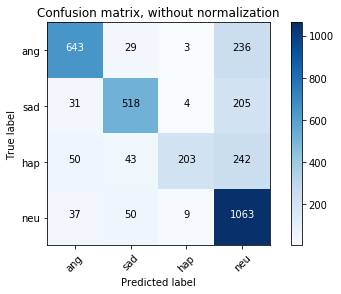

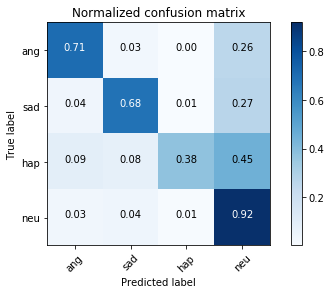

In [371]:
train_predictions = model.predict(data, verbose=1)
# plt.hist(train_predictions)
# test_predictions = model.predict([TEST_DATA_AR[Dindex]],verbose=1)
# plt.hist(test_predictions)

y_pred = np.argmax(train_predictions,axis=1)
y_true = np.argmax(y_train,axis=1)
cnf_matrix = confusion_matrix(y_true,y_pred)
EMO_SET = ['ang', 'sad', 'hap', 'neu']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=EMO_SET,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=EMO_SET, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

842/842 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
Normalized confusion matrix


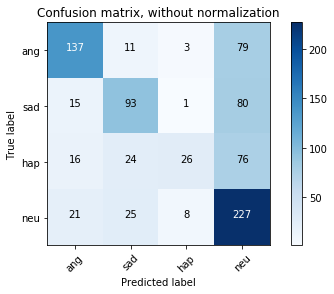

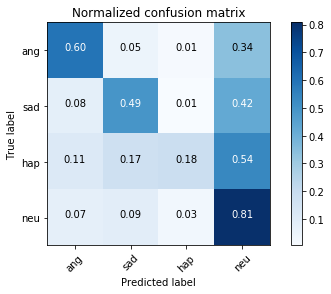

In [372]:
# train_predictions = model.predict([dataV], verbose=1)
# plt.hist(train_predictions)
test_predictions = model.predict([TEST_DATA_AR[Dindex]],verbose=1)
# plt.hist(test_predictions)

y_pred = np.argmax(test_predictions,axis=1)
y_true = np.argmax(y_test,axis=1)
cnf_matrix = confusion_matrix(y_true,y_pred)
EMO_SET = ['ang', 'sad', 'hap', 'neu']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=EMO_SET,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=EMO_SET, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [370]:
get_scores_from_multiple('history/rmse/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
2,_FS1_1_1_FM_150_data_cw.pkl,0.843568,0.810036,0.917972,0.983671
7,_FS1_1_1_FM_150_data_wc.pkl,0.843078,0.809026,0.913673,0.978675
12,_FS1_1_1_FM_150_data_full.pkl,0.842736,0.808670,0.916785,0.981181
17,_FS1_1_1_FM_100_data_full.pkl,0.836557,0.804810,0.944705,1.005316
15,_FS1_2_2_FM_150_data_wc.pkl,0.837394,0.804632,0.876767,0.936163
0,_FS1_2_3_FM_150_data_full.pkl,0.833754,0.804137,0.854709,0.910466
11,_FS1_2_2_FM_150_data_cw.pkl,0.835710,0.802751,0.876312,0.934580
3,_FS1_2_2_FM_150_data_full.pkl,0.838879,0.802652,0.867716,0.928262
9,_FS1_2_3_FM_150_data_cw.pkl,0.834769,0.802553,0.860108,0.917960
4,_FS1_2_3_FM_150_data_wc.pkl,0.833309,0.802454,0.851820,0.908359


In [369]:
get_scores_from_multiple('history/zcr/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
7,_FS1_1_1_FM_150_data_wc.pkl,0.844177,0.810669,0.924053,0.989819
12,_FS1_1_1_FM_150_data_full.pkl,0.843212,0.809580,0.920701,0.985644
2,_FS1_1_1_FM_150_data_cw.pkl,0.845663,0.807898,0.903753,0.971623
11,_FS1_2_2_FM_150_data_cw.pkl,0.837369,0.804236,0.867452,0.928122
15,_FS1_2_2_FM_150_data_wc.pkl,0.837765,0.803741,0.872488,0.932890
9,_FS1_2_3_FM_150_data_cw.pkl,0.834497,0.803543,0.849514,0.906334
3,_FS1_2_2_FM_150_data_full.pkl,0.836849,0.803444,0.873684,0.933032
8,_FS1_3_5_FM_150_data_wc.pkl,0.834348,0.802949,0.819095,0.875479
0,_FS1_2_3_FM_150_data_full.pkl,0.834398,0.801267,0.858987,0.916440
4,_FS1_2_3_FM_150_data_wc.pkl,0.836205,0.801168,0.853527,0.911965


In [368]:
get_scores_from_multiple('history/mfcc1/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
7,_FS1_1_1_FM_150_data_wc.pkl,0.844004,0.811065,0.921636,0.987423
2,_FS1_1_1_FM_150_data_cw.pkl,0.844004,0.810966,0.920558,0.985483
12,_FS1_1_1_FM_150_data_full.pkl,0.841330,0.809778,0.923572,0.987005
3,_FS1_2_2_FM_150_data_full.pkl,0.834348,0.803345,0.872582,0.932007
0,_FS1_2_3_FM_150_data_full.pkl,0.833853,0.803048,0.858965,0.914285
8,_FS1_3_5_FM_150_data_wc.pkl,0.833581,0.802949,0.816730,0.872028
4,_FS1_2_3_FM_150_data_wc.pkl,0.832813,0.802257,0.863683,0.917917
9,_FS1_2_3_FM_150_data_cw.pkl,0.830808,0.801762,0.861830,0.916049
11,_FS1_2_2_FM_150_data_cw.pkl,0.832492,0.800772,0.872027,0.928763
15,_FS1_2_2_FM_150_data_wc.pkl,0.833878,0.800673,0.873665,0.931298
